=== 改进的逻辑回归训练 ===

1. 加载融合特征...
训练集: (3600, 512)
验证集: (400, 512)
训练标签分布: [1074  377 2149]
验证标签分布: [119  42 239]

2. 数据增强（中立类别）...
数据增强: 原始中立样本 377 个，新增 377 个
增强后训练集: (3977, 512)
增强后标签分布: [1074  754 2149]

3. 训练优化模型...
=== 逻辑回归优化训练（重点改进中立类别） ===
类别分布: [1074  754 2149]
类别比例: [0.2700528  0.18959014 0.54035705]
计算的自定义类别权重: {0: np.float64(1.234326505276226), 1: np.float64(4.395446507515473), 2: np.float64(0.6168760663874671)}


训练进度: 100%|███████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]



优化训练完成！
训练耗时: 132.57 秒
模型参数: 求解器=saga, C=0.5, penalty=elasticnet, l1_ratio=0.5
=== 验证集 评估结果 ===
准确率: 0.6500
加权F1分数: 0.6620
宏平均F1分数: 0.5606

详细分类报告:
              precision  recall  f1-score  support
0                0.6116  0.6218    0.6167   119.00
1                0.2656  0.4048    0.3208    42.00
2                0.7860  0.7071    0.7445   239.00
accuracy         0.6500  0.6500    0.6500     0.65
macro avg        0.5544  0.5779    0.5606   400.00
weighted avg     0.6795  0.6500    0.6620   400.00

中立类别错误分析:
  中立类别假阴性（漏报）: 25 个样本
  中立类别假阳性（误报）: 47 个样本
  被误判为中立的真实标签分布:
    negative: 16 个
    positive: 31 个

改进训练成功！

4. 阈值调整实验...

概率分布分析:
类别 0: 平均概率=0.3095, 标准差=0.3417
类别 1: 平均概率=0.1760, 标准差=0.3090
类别 2: 平均概率=0.5145, 标准差=0.3777
=== 验证集 阈值调整实验 ===

[策略1] 降低中立类别阈值后的结果:
准确率: 0.6375
加权F1分数: 0.6549
宏平均F1分数: 0.5510
  negative F1分数: 0.6043
  neutral F1分数: 0.3077
  positive F1分数: 0.7411

[策略2] 自定义决策规则（优先考虑中立）:
准确率: 0.6150
加权F1分数: 0.6465
宏平均F1分数: 0.5354
  negative F1分数: 0.5882
  neutral F1分数: 0

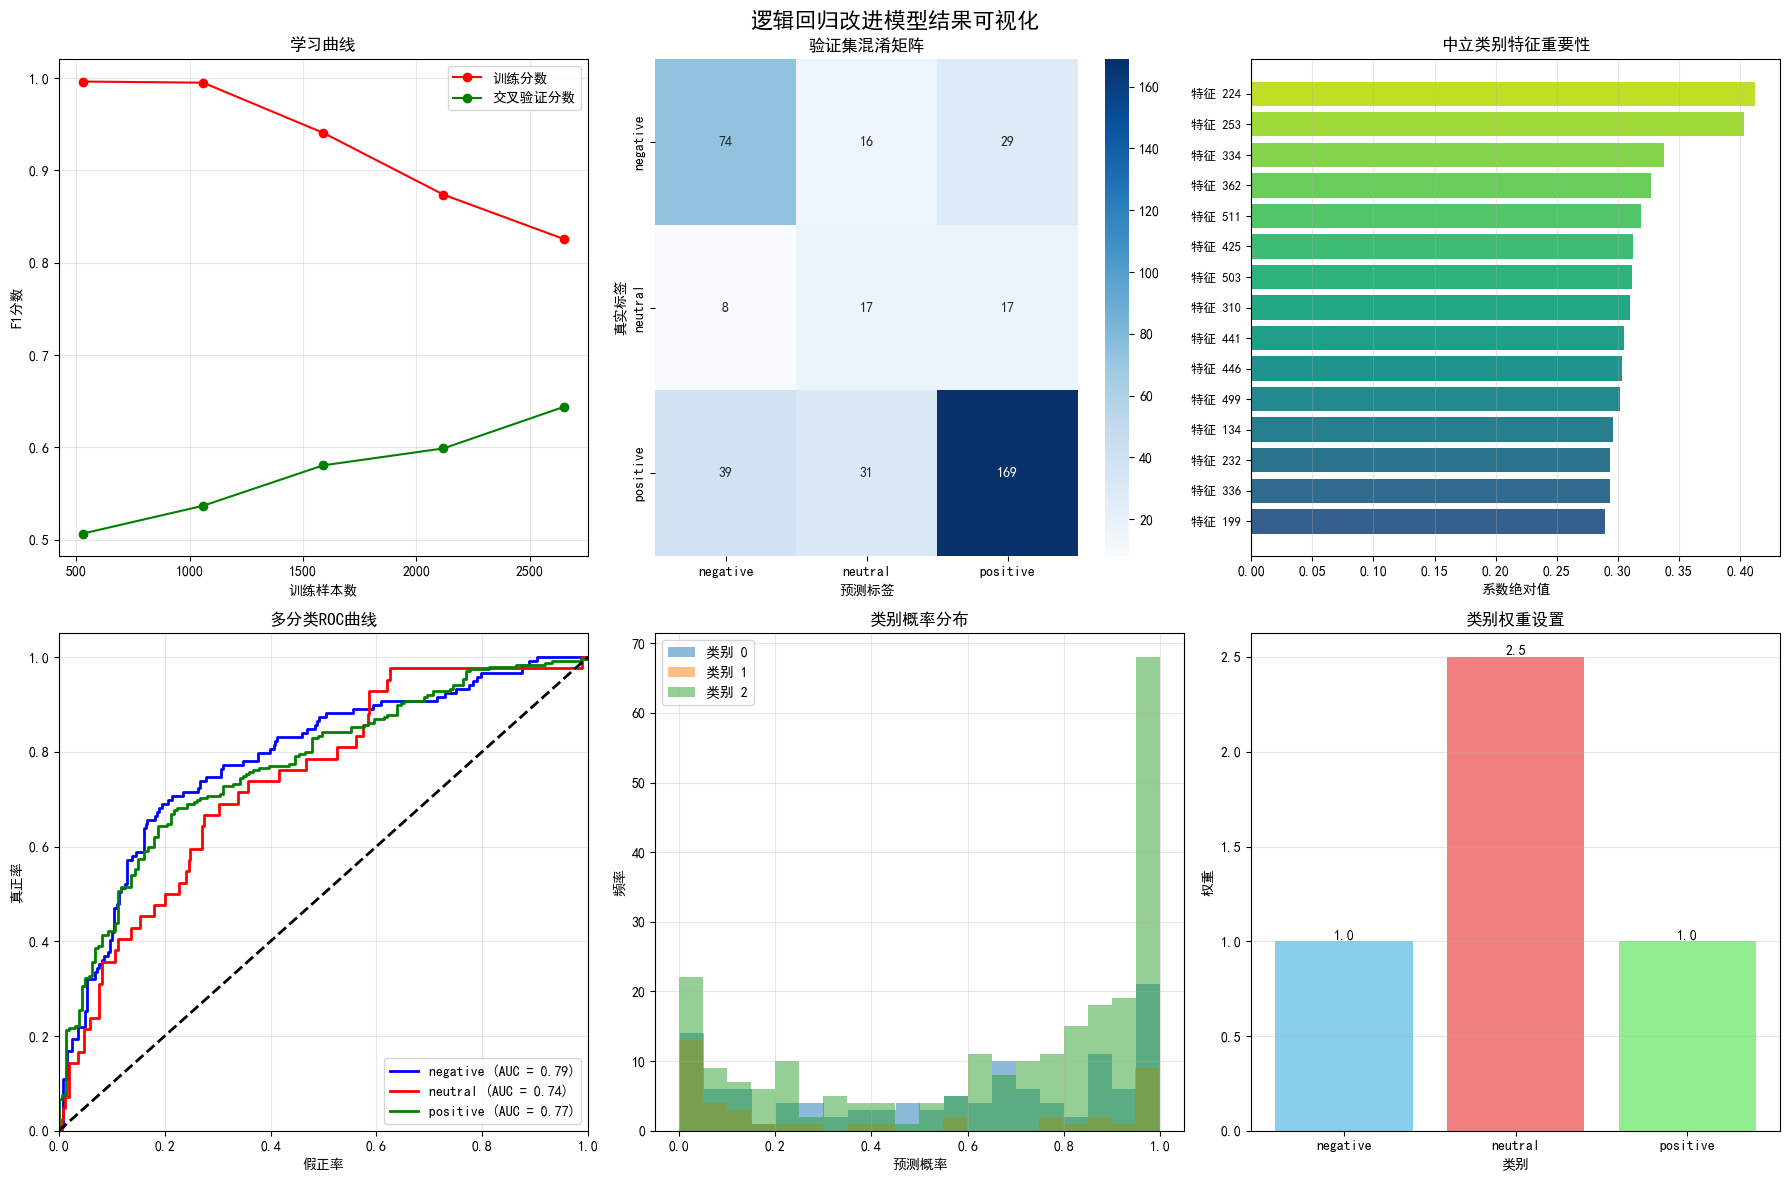


6. 保存模型...

模型已保存到: ./data/models/logistic_regression_improved.pkl
模型摘要已保存到: ./data/models/logistic_regression_improved_summary.txt
改进的逻辑回归训练流程完成!
总训练时间: 132.57 秒

训练完成，模型已保存。


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
import warnings
import os
import joblib
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

randomseed = 42

# 针对neutral改善的逻辑回归训练器
class ImprovedLogisticRegressionTrainer:
    def __init__(self, random_state=randomseed):
        self.random_state = random_state
        self.best_model = None
        self.training_time = None
    
    def train_with_balanced_focus(self, X_train, y_train, X_val=None, y_val=None):
        print("=== 逻辑回归优化训练（重点改进中立类别） ===")
        
        start_time = time.time()
        
        # 分析类别分布
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        n_classes = len(class_counts)
        
        print(f"类别分布: {class_counts}")
        print(f"类别比例: {class_counts / total_samples}")
        
        # 计算类别权重（给中立类别更高的权重）
        # 方法1：根据类别频率的倒数
        class_weights = {}
        for i in range(n_classes):
            if class_counts[i] > 0:
                # 给中立类别(1)额外权重
                if i == 1:  # 中立类别
                    class_weights[i] = total_samples / (n_classes * class_counts[i]) * 2.5  # 中立类别权重增加2.5倍
                else:
                    class_weights[i] = total_samples / (n_classes * class_counts[i])
        
        print(f"计算的自定义类别权重: {class_weights}")
        
        # 根据类别数量选择最佳求解器
        if n_classes > 2:
            solver = 'saga'
            multi_class = 'multinomial'
        else:
            solver = 'liblinear'
            multi_class = 'auto'
        
        with tqdm(total=100, desc="训练进度", ncols=80) as pbar:
            model = LogisticRegression(
                solver=solver,
                multi_class=multi_class,
                C=1.0,
                max_iter=3000,
                random_state=self.random_state,
                class_weight=class_weights,
                penalty='elasticnet',  # 弹性网正则化
                l1_ratio=0.5,  # L1和L2的混合比例
                verbose=0
            )
                
            model.fit(X_train, y_train)
            pbar.update(100)
        
        self.best_model = model
        self.training_time = time.time() - start_time
        
        print(f"\n优化训练完成！")
        print(f"训练耗时: {self.training_time:.2f} 秒")
        print(f"模型参数: 求解器={solver}, C=0.5, penalty=elasticnet, l1_ratio=0.5")
        
        # 在验证集上评估
        if X_val is not None and y_val is not None:
            val_metrics = self.evaluate_model(X_val, y_val, set_name="验证集")
    
            # 特别分析中立类别的错误
            self._analyze_neutral_class_errors(X_val, y_val)
        
        return self.best_model
    
    # 逻辑回归简单训练，用于对比
    def train_fast(self, X_train, y_train, X_val=None, y_val=None):
        print("=== 逻辑回归简单快速训练 ===")
        
        start_time = time.time()
        
        # 创建并训练模型
        model = LogisticRegression(
            solver='lbfgs',
            multi_class='multinomial',
            C=1.0,
            max_iter=1000,
            random_state=self.random_state,
            class_weight='balanced'
        )
        
        with tqdm(total=100, desc="训练进度", ncols=80) as pbar:
            model.fit(X_train, y_train)
            pbar.update(100)

        self.best_model = model
        self.training_time = time.time() - start_time
        
        print(f"\n✅ 简单训练完成！")
        print(f"训练耗时: {self.training_time:.2f} 秒")
        
        return self.best_model
    
    # 性能评估
    def evaluate_model(self, X, y, set_name="测试集"):
        # 获取标准预测
        y_pred = self.best_model.predict(X)
        
        # 计算评估指标
        accuracy = accuracy_score(y, y_pred)
        f1_weighted = f1_score(y, y_pred, average='weighted')
        f1_macro = f1_score(y, y_pred, average='macro')
        
        print(f"=== {set_name} 评估结果 ===")
        print(f"准确率: {accuracy:.4f}")
        print(f"加权F1分数: {f1_weighted:.4f}")
        print(f"宏平均F1分数: {f1_macro:.4f}")
        
        # 分类报告
        report = classification_report(y, y_pred, output_dict=True)
        print(f"\n详细分类报告:")
        report_df = pd.DataFrame(report).transpose()
        print(report_df[['precision', 'recall', 'f1-score', 'support']].round(4))
        
        return {
            'accuracy': accuracy,
            'f1_weighted': f1_weighted,
            'f1_macro': f1_macro,
            'predictions': y_pred,
            'report': report
        }
    
    def evaluate_with_threshold_adjustment(self, X, y, set_name="测试集"):
        # 获取预测概率
        if hasattr(self.best_model, 'predict_proba'):
            y_pred_proba = self.best_model.predict_proba(X)
            
            # 分析概率分布
            print(f"\n概率分布分析:")
            for i in range(y_pred_proba.shape[1]):
                probs = y_pred_proba[:, i]
                print(f"类别 {i}: 平均概率={probs.mean():.4f}, 标准差={probs.std():.4f}")
            
            # 尝试不同的阈值策略
            print(f"=== {set_name} 阈值调整实验 ===")
            
            # 策略1：降低中立类别的阈值要求
            y_pred_adjusted = self._adjust_thresholds(y_pred_proba, neutral_bias=1.5)  # 中立类别阈值降低50%
            
            # 评估调整后的结果
            print(f"\n[策略1] 降低中立类别阈值后的结果:")
            self._print_classification_report(y, y_pred_adjusted)
            
            # 策略2：使用自定义决策规则
            print(f"\n[策略2] 自定义决策规则（优先考虑中立）:")
            y_pred_custom = self._custom_decision_rule(y_pred_proba)
            self._print_classification_report(y, y_pred_custom)
            
            # 策略3：中性偏向的阈值调整
            print(f"\n[策略3] 中性偏向的阈值调整:")
            y_pred_neutral = self._neutral_focused_threshold(y_pred_proba, neutral_threshold=0.3)
            self._print_classification_report(y, y_pred_neutral)
            
            # 返回最佳策略的预测结果
            return y_pred_custom  # 返回自定义决策规则的结果
        
        return self.best_model.predict(X)
    
    # 调整决策阈值
    def _adjust_thresholds(self, probabilities, neutral_bias=1.0):
        # 默认使用最大概率
        if neutral_bias == 1.0:
            return np.argmax(probabilities, axis=1)
        
        # 调整概率（增加中立类别的权重）
        adjusted_probs = probabilities.copy()
        adjusted_probs[:, 1] *= neutral_bias  # 中立类别是索引1
        
        return np.argmax(adjusted_probs, axis=1)
    
    def _custom_decision_rule(self, probabilities):
        n_samples = probabilities.shape[0]
        predictions = np.zeros(n_samples, dtype=int)
        
        for i in range(n_samples):
            probs = probabilities[i]
            
            # 如果最大概率低于阈值，且两个类别概率接近，则预测为中立
            max_prob = np.max(probs)
            if max_prob < 0.6:  # 置信度不高
                sorted_probs = np.sort(probs)
                if sorted_probs[-1] - sorted_probs[-2] < 0.25:  # 前两个类别概率接近
                    predictions[i] = 1  # 预测为中立
                else:
                    predictions[i] = np.argmax(probs)
            else:
                predictions[i] = np.argmax(probs)
        
        return predictions
    
    def _neutral_focused_threshold(self, probabilities, neutral_threshold=0.3):
        n_samples = probabilities.shape[0]
        predictions = np.zeros(n_samples, dtype=int)
        
        for i in range(n_samples):
            probs = probabilities[i]
            
            # 如果中立类别的概率超过阈值，就预测为中立
            if probs[1] >= neutral_threshold:  # 中立类别是索引1
                predictions[i] = 1
            else:
                predictions[i] = np.argmax(probs)
        
        return predictions
    
    # 打印分类报告
    def _print_classification_report(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        
        print(f"准确率: {accuracy:.4f}")
        print(f"加权F1分数: {f1_weighted:.4f}")
        print(f"宏平均F1分数: {f1_macro:.4f}")
        
        # 按类别显示F1分数
        f1_scores = f1_score(y_true, y_pred, average=None)
        for i, score in enumerate(f1_scores):
            label = ['negative', 'neutral', 'positive'][i] if i < 3 else f'class{i}'
            print(f"  {label} F1分数: {score:.4f}")
    
    # 错误分析
    def _analyze_neutral_class_errors(self, X, y):
        y_pred = self.best_model.predict(X)
        
        # 找出中立类别的错误预测
        neutral_true = (y == 1)
        neutral_pred = (y_pred == 1)
        
        # 假阴性
        false_negative = neutral_true & (~neutral_pred)
        fn_count = false_negative.sum()
        
        # 假阳性
        false_positive = (~neutral_true) & neutral_pred
        fp_count = false_positive.sum()
        
        print(f"\n中立类别错误分析:")
        print(f"  中立类别假阴性（漏报）: {fn_count} 个样本")
        print(f"  中立类别假阳性（误报）: {fp_count} 个样本")
        
        # 分析哪些类别被误判为中立
        if fp_count > 0:
            fp_indices = np.where(false_positive)[0]
            fp_true_labels = y[fp_indices]
            unique_labels, counts = np.unique(fp_true_labels, return_counts=True)
            print(f"  被误判为中立的真实标签分布:")
            for label, count in zip(unique_labels, counts):
                label_name = ['negative', 'neutral', 'positive'][label] if label < 3 else f'class{label}'
                print(f"    {label_name}: {count} 个")
    
    def visualize_results(self, X_train, y_train, X_val=None, y_val=None):
        print("\n生成可视化结果...")
        
        # 创建可视化画布
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('逻辑回归改进模型结果可视化', fontsize=16, fontweight='bold')
        
        # 1. 学习曲线
        self._plot_learning_curve(X_train, y_train, axes[0, 0])
        
        # 2. 验证集混淆矩阵
        if X_val is not None and y_val is not None:
            self._plot_confusion_matrix(X_val, y_val, axes[0, 1], title="验证集混淆矩阵")
        
        # 3. 特征系数重要性
        self._plot_feature_coefficients(axes[0, 2])
        
        # 4. ROC曲线
        if X_val is not None and y_val is not None:
            self._plot_roc_curve(X_val, y_val, axes[1, 0])
        
        # 5. 类别概率分布
        if X_val is not None and y_val is not None:
            self._plot_class_probabilities(X_val, y_val, axes[1, 1])
        
        # 6. 类别权重影响
        self._plot_class_weight_effect(axes[1, 2])
        
        plt.tight_layout()
        plt.savefig('./data/splits/logistic_regression_improved_results.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    def _plot_learning_curve(self, X_train, y_train, ax):
        from sklearn.model_selection import learning_curve
        
        train_sizes, train_scores, test_scores = learning_curve(
            self.best_model, X_train, y_train,
            cv=3, scoring='f1_weighted',
            train_sizes=np.linspace(0.2, 1.0, 5),
            n_jobs=1
        )
        
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        
        ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='训练分数')
        ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='交叉验证分数')
        ax.set_xlabel('训练样本数')
        ax.set_ylabel('F1分数')
        ax.set_title('学习曲线')
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    def _plot_confusion_matrix(self, X, y, ax, title="混淆矩阵"):
        y_pred = self.best_model.predict(X)
        cm = confusion_matrix(y, y_pred)
        
        # 获取类别标签
        classes = np.unique(y)
        class_labels = ['negative', 'neutral', 'positive'][:len(classes)]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels,
                   ax=ax)
        ax.set_title(title)
        ax.set_xlabel('预测标签')
        ax.set_ylabel('真实标签')
    
    def _plot_feature_coefficients(self, ax):
        if hasattr(self.best_model, 'coef_'):
            coef = self.best_model.coef_
            
            # 对多分类，计算每个特征的绝对系数平均值
            if len(coef.shape) > 1:
                # 特别关注中立类别的特征重要性
                neutral_importance = np.abs(coef[1, :]) if coef.shape[0] > 1 else np.abs(coef[0, :])
                importance = neutral_importance
                title = '中立类别特征重要性'
            else:
                importance = np.abs(coef)
                title = '特征重要性'
            
            # 取最重要的15个特征
            top_n = min(15, len(importance))
            top_indices = np.argsort(importance)[-top_n:]
            top_importance = importance[top_indices]
            
            # 创建特征名称
            feature_names = [f'特征 {i}' for i in top_indices]
            
            colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
            ax.barh(range(top_n), top_importance, color=colors)
            ax.set_yticks(range(top_n))
            ax.set_yticklabels(feature_names, fontsize=9)
            ax.set_xlabel('系数绝对值')
            ax.set_title(title)
            ax.grid(True, alpha=0.3, axis='x')
        else:
            ax.text(0.5, 0.5, '模型无系数属性', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('特征重要性')
    
    def _plot_roc_curve(self, X, y, ax):
        if hasattr(self.best_model, 'predict_proba'):
            y_prob = self.best_model.predict_proba(X)
            
            # 二值化标签
            classes = np.unique(y)
            y_bin = label_binarize(y, classes=classes)
            n_classes = y_bin.shape[1]
            
            # 计算每个类别的ROC曲线
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            # 绘制ROC曲线
            colors = ['blue', 'red', 'green'][:n_classes]
            class_labels = ['negative', 'neutral', 'positive']
            
            for i, color in zip(range(n_classes), colors):
                label = class_labels[i] if i < len(class_labels) else f'类别{i}'
                ax.plot(fpr[i], tpr[i], color=color, lw=2,
                       label=f'{label} (AUC = {roc_auc[i]:.2f})')
            
            ax.plot([0, 1], [0, 1], 'k--', lw=2)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('假正率')
            ax.set_ylabel('真正率')
            ax.set_title('多分类ROC曲线')
            ax.legend(loc='lower right')
            ax.grid(True, alpha=0.3)
    
    def _plot_class_probabilities(self, X, y, ax):
        if hasattr(self.best_model, 'predict_proba'):
            y_prob = self.best_model.predict_proba(X)
            
            # 为每个类别绘制概率分布
            n_classes = y_prob.shape[1]
            class_labels = ['negative', 'neutral', 'positive']
            
            for i in range(n_classes):
                class_probs = y_prob[y == i, i] if i < len(class_labels) else y_prob[:, i]
                ax.hist(class_probs, bins=20, alpha=0.5, label=f'类别 {i}')
            
            ax.set_xlabel('预测概率')
            ax.set_ylabel('频率')
            ax.set_title('类别概率分布')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    def _plot_class_weight_effect(self, ax):
        if hasattr(self.best_model, 'classes_'):
            n_classes = len(self.best_model.classes_)
            weights = [1.0, 2.5, 1.0]  # 给中立类别更高权重
            
            colors = ['skyblue', 'lightcoral', 'lightgreen']
            class_labels = ['negative', 'neutral', 'positive']
            
            bars = ax.bar(range(n_classes), weights[:n_classes], color=colors)
            
            # 添加数值标签
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}', ha='center', va='bottom')
            
            ax.set_xlabel('类别')
            ax.set_ylabel('权重')
            ax.set_title('类别权重设置')
            ax.set_xticks(range(n_classes))
            ax.set_xticklabels(class_labels[:n_classes])
            ax.grid(True, alpha=0.3, axis='y')
    
    # 保存模型
    def save_model(self, model_name='logistic_regression_improved'):
        os.makedirs('./data/models', exist_ok=True)
        model_path = f'./data/models/{model_name}.pkl'
        
        # 保存模型和元数据
        model_data = {
            'model': self.best_model,
            'training_time': self.training_time,
            'random_state': self.random_state
        }
        
        joblib.dump(model_data, model_path)
        print(f"\n模型已保存到: {model_path}")
        
        # 保存模型摘要
        summary_path = f'./data/models/{model_name}_summary.txt'
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(self._generate_model_summary())
        
        print(f"模型摘要已保存到: {summary_path}")
    
    # 声称报告
    def _generate_model_summary(self):
        summary = f"""
=== 改进的逻辑回归模型训练摘要 ===

训练时间: {time.strftime('%Y-%m-%d %H:%M:%S')}
训练耗时: {self.training_time:.2f} 秒

模型配置:
  求解器: {self.best_model.get_params().get('solver', 'N/A')}
  正则化强度(C): {self.best_model.get_params().get('C', 'N/A')}
  正则化类型: {self.best_model.get_params().get('penalty', 'N/A')}
  最大迭代次数: {self.best_model.get_params().get('max_iter', 'N/A')}
  类别权重: {self.best_model.get_params().get('class_weight', 'N/A')}
  多分类策略: {self.best_model.get_params().get('multi_class', 'N/A')}

收敛状态:
  实际迭代次数: {self.best_model.n_iter_ if hasattr(self.best_model, 'n_iter_') else 'N/A'}
"""
        return summary

def augment_neutral_samples(X, y, augmentation_factor=2):
    # 分离不同类别的样本
    neutral_idx = np.where(y == 1)[0]
    
    if len(neutral_idx) == 0:
        return X, y
    
    X_neutral = X[neutral_idx]
    
    # 生成新的中立样本（通过添加轻微噪声）
    n_needed = int(len(neutral_idx) * (augmentation_factor - 1))
    
    if n_needed > 0:
        # 随机选择现有中立样本进行复制并添加噪声
        indices = np.random.choice(len(neutral_idx), n_needed, replace=True)
        X_augmented = X_neutral[indices]
        
        # 添加轻微高斯噪声
        noise = np.random.normal(0, 0.01, X_augmented.shape)
        X_augmented = X_augmented + noise
        
        # 合并原始和增强数据
        X_combined = np.vstack([X, X_augmented])
        y_combined = np.hstack([y, np.ones(n_needed, dtype=int)])
        
        print(f"数据增强: 原始中立样本 {len(neutral_idx)} 个，新增 {n_needed} 个")
        return X_combined, y_combined
    
    return X, y

def improved_logistic_regression_pipeline(use_augmentation=True):
    """改进的逻辑回归训练流程（专注于提升中立类别表现）"""
    
    # 1. 加载融合特征
    print("\n1. 加载融合特征...")
    fusion_dir = './data/splits/fusion'
    
    train_fused = np.load(os.path.join(fusion_dir, 'train_fused.npy'))
    val_fused = np.load(os.path.join(fusion_dir, 'val_fused.npy'))
    train_labels = np.load(os.path.join(fusion_dir, 'train_labels.npy'))
    val_labels = np.load(os.path.join(fusion_dir, 'val_labels.npy'))
        
    print(f"训练集: {train_fused.shape}")
    print(f"验证集: {val_fused.shape}")
    print(f"训练标签分布: {np.bincount(train_labels)}")
    print(f"验证标签分布: {np.bincount(val_labels)}")
    
    # 2. 数据增强（为中立类别生成更多样本）
    if use_augmentation:
        print("\n2. 数据增强（中立类别）...")
        X_augmented, y_augmented = augment_neutral_samples(train_fused, train_labels, augmentation_factor=2.0)
        print(f"增强后训练集: {X_augmented.shape}")
        print(f"增强后标签分布: {np.bincount(y_augmented)}")
    else:
        X_augmented, y_augmented = train_fused, train_labels
        print("\n2. 跳过数据增强...")
    
    # 3. 训练优化模型
    print("\n3. 训练优化模型...")
    trainer = ImprovedLogisticRegressionTrainer(random_state=randomseed)
    
    try:
        # 使用优化训练方法
        trainer.train_with_balanced_focus(
            X_augmented, y_augmented,
            X_val=val_fused, y_val=val_labels
        )
        
        print("\n改进训练成功！")
        
        # 4. 详细评估（包括阈值调整）
        print("\n4. 阈值调整实验...")
        trainer.evaluate_with_threshold_adjustment(val_fused, val_labels, "验证集")
        
        # 5. 可视化结果
        print("\n5. 可视化结果...")
        trainer.visualize_results(
            X_augmented, y_augmented,
            X_val=val_fused, y_val=val_labels
        )
        
        # 6. 保存模型
        print("\n6. 保存模型...")
        trainer.save_model('logistic_regression_improved')
        
        return trainer
        
    except Exception as e:
        print(f"\n训练失败: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# 执行改进的逻辑回归训练流程
if __name__ == "__main__":
    print("=== 改进的逻辑回归训练 ===")
    trainer = improved_logistic_regression_pipeline(use_augmentation=True)
    
    print("改进的逻辑回归训练流程完成!")
    print(f"总训练时间: {trainer.training_time:.2f} 秒")
    print("\n训练完成，模型已保存。")